In [131]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
import pickle

## Load data

In [132]:
results_folder = f'sampling_louvain_results_knn/'

def get_cluster_df(sample_size, i, drop_asd=True):
    folder_path = f"{results_folder}/{sample_size}/{i}"
    df = pd.read_pickle(f"{folder_path}/sample_df.pkl")
    
    # Calculate mean 'asd' value for each cluster
    cluster_means = df.groupby('cluster')['asd'].mean().sort_values()
    
    # Create a mapping from old cluster labels to new cluster labels
    cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(cluster_means.index)}
    
    # Reassign cluster labels
    df['cluster'] = df['cluster'].map(cluster_mapping)
    
    if drop_asd:
        df = df.drop("asd", axis=1)
    
    return df
def get_communinies(sample_size, i ):
    folder_path = f"{results_folder}/{sample_size}/{i}"
    with open(f"{folder_path}/communities.pkl", 'rb') as file:
        communities = pickle.load(file)
    return communities

In [133]:
sample_dfs = []
for i in range(5):
    sample_df = get_cluster_df(20000, i)
    sample_dfs.append(sample_df)
    # print(len(get_communinies(20000, i)))


In [134]:
concatenated_df = pd.concat(sample_dfs)
print(concatenated_df.shape)

(100000, 29)


In [135]:
unique_indices_count = concatenated_df['index'].nunique()
print(f"Number of unique 'index' values: {unique_indices_count}")

Number of unique 'index' values: 73924


In [136]:
concatenated_df

,index,dev_lang,dev_lang_dis,sex,attn_behav,dev_speech,dev_soc_prag,birth_oth_calc,dev_motor,behav_adhd,...,mood_dmd,mood_bipol,multiple_birth,mood_or_anx,gen_dx_oth_calc_self_report,mood_hoard,behav_intermitt_explos,behav_conduct,dev_mutism,cluster
0,112470,1.0,1.0,1,1.0,1.0,0.0,0,0.0,1.0,...,0.0,1.0,0,1.0,0,0.0,1.0,0.0,0.0,4
1,33039,0.0,0.0,1,0.0,0.0,0.0,1,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,2
2,10254,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1
3,102928,1.0,0.0,0,0.0,0.0,1.0,0,1.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,4
4,71006,1.0,0.0,1,0.0,0.0,0.0,1,1.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,25555,0.0,0.0,1,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,2
19996,66637,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1
19997,84123,0.0,0.0,1,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,1.0,0,0.0,0.0,0.0,0.0,2
19998,94772,1.0,0.0,0,0.0,0.0,0.0,1,1.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,4


In [137]:
from collections import Counter

def keep_majority_vote(concatenated_df):
    # Function to determine the majority vote
    def majority_vote(cluster_series):
        count = Counter(cluster_series)
        most_common = count.most_common()
        if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:
            return most_common[0][0]
        else:
            return None

    # Group by 'index' column and apply the majority vote function
    grouped = concatenated_df.groupby('index')
    majority_clusters = grouped['cluster'].apply(majority_vote)

    # Filter out indices with no majority
    majority_clusters = majority_clusters.dropna()

    # Keep only rows with the majority vote
    filtered_df = concatenated_df[concatenated_df['index'].isin(majority_clusters.index)]
    filtered_df = filtered_df[filtered_df.apply(lambda row: row['cluster'] == majority_clusters[row['index']], axis=1)]

    # Drop all duplicated 'index' rows
    filtered_df = filtered_df.drop_duplicates(subset='index', keep='first')

    return filtered_df


filtered_concatenated_df = keep_majority_vote(concatenated_df)
# selected_rows = concatenated_df.loc[concatenated_df['index'].isin([0, 2, 83, 1, 5, 442])]
# print(selected_rows[['index', 'cluster']].sort_values('index'))
# df = keep_majority_vote(selected_rows)
# df[['index', 'cluster']].sort_values('index')

In [138]:
def check_clusters(df):
    grouped = df.groupby('index')['cluster']
    for index, group in grouped:
        if group.nunique() == 1:
            # All 'cluster' values are the same, no need to print
            continue
        else:
            print(f"Index {index}: 'Cluster' values are different. Clusters: {group.tolist()}")

check_clusters(filtered_concatenated_df)

In [169]:
# spark_df = get_cluster_df(20000, 0)
spark_df = filtered_concatenated_df
spark_df = spark_df.drop('index', axis=1)
print(spark_df.columns)
print(spark_df.shape)

Index(['dev_lang', 'dev_lang_dis', 'sex', 'attn_behav', 'dev_speech',
       'dev_soc_prag', 'birth_oth_calc', 'dev_motor', 'behav_adhd', 'dev_ld',
       'neuro_oth_calc', 'psych_oth_calc', 'behav_odd', 'mood_dep',
       'mood_soc_anx', 'mood_anx', 'mood_ocd', 'mood_sep_anx', 'mood_dmd',
       'mood_bipol', 'multiple_birth', 'mood_or_anx',
       'gen_dx_oth_calc_self_report', 'mood_hoard', 'behav_intermitt_explos',
       'behav_conduct', 'dev_mutism', 'cluster'],
      dtype='object')
(71034, 28)


In [140]:
# check check number of null values in each field
spark_df.apply(lambda x: x.isnull().sum())

dev_lang                       0
dev_lang_dis                   0
sex                            0
attn_behav                     0
dev_speech                     0
dev_soc_prag                   0
birth_oth_calc                 0
dev_motor                      0
behav_adhd                     0
dev_ld                         0
neuro_oth_calc                 0
psych_oth_calc                 0
behav_odd                      0
mood_dep                       0
mood_soc_anx                   0
mood_anx                       0
mood_ocd                       0
mood_sep_anx                   0
mood_dmd                       0
mood_bipol                     0
multiple_birth                 0
mood_or_anx                    0
gen_dx_oth_calc_self_report    0
mood_hoard                     0
behav_intermitt_explos         0
behav_conduct                  0
dev_mutism                     0
cluster                        0
dtype: int64

In [141]:
# create dataset
# target_var = 'asd'
target_var = 'cluster'
feature_space = spark_df.iloc[:, spark_df.columns != 'cluster']
feature_class = spark_df.iloc[:, spark_df.columns == 'cluster']

# train_test_split in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20, 
                                                                    random_state = 42)
# X_train, X_test, y_train, y_test

# Cleaning test sets to avoid future warning messages
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()

In [142]:
set(y_train)

{0, 1, 2, 3, 4}

In [143]:
from collections import Counter

def print_value_counts(y, dataset_name):
    counter = Counter(y)
    total = len(y)
    print(f"Value counts for {dataset_name}:")
    for value in sorted(counter.keys()):  # Sort the keys before iterating
        count = counter[value]
        percentage = (count / total) * 100
        print(f"Value {value}: {count} times ({percentage:.2f}%)")
    print()

print_value_counts(y_train, "y_train")
print_value_counts(y_test, "y_test")

Value counts for y_train:
Value 0: 7743 times (13.63%)
Value 1: 11290 times (19.87%)
Value 2: 12975 times (22.83%)
Value 3: 6762 times (11.90%)
Value 4: 18057 times (31.78%)

Value counts for y_test:
Value 0: 1926 times (13.56%)
Value 1: 2771 times (19.50%)
Value 2: 3255 times (22.91%)
Value 3: 1713 times (12.06%)
Value 4: 4542 times (31.97%)



In [144]:
# instantiate classifier 
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=10)

## Parameter grid search

In [129]:
np.random.seed(42)
start = time.time()

# give to GridSearchCV

# param_dist = {'max_depth': [5, 10, 20],
#  'bootstrap': [True, False],
#  'max_features': ['sqrt', 'log2'],
#  'criterion': ['gini', 'entropy'],
#  'n_estimators': [20, 100, 200]}

param_dist = {'max_depth': [10],
 'bootstrap': [False],
 'max_features': ['sqrt'],
 'criterion': ['entropy'],
 'n_estimators': [200]}

# param_dist = {'max_depth': [2, 5, 10, 20, None],
#  'bootstrap': [True, False],
#  'max_features': ['sqrt', 'log2'],
#  'criterion': ['gini', 'entropy'],
#  'n_estimators': [10, 20, 40, 80, 100, 200, 500]}

# set up the GridSearch
cv_rf = GridSearchCV(rf_classifier, cv = 5,
                     param_grid=param_dist, 
                     n_jobs = 3, return_train_score=True)

# fit the GridSearch
cv_rf.fit(X_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)


end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Time taken in grid search:  7.13


In [99]:
print("Best parameters:", cv_rf.best_params_)
print("Best score:", cv_rf.best_score_)

Best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Best score: 0.94184105093734


In [130]:
cv_rf.cv_results_['mean_train_score'][cv_rf.best_index_]

0.9419642087740527

In [100]:
cv_results = cv_rf.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print("Mean Score:", mean_score)
    print("Parameters:", params)
    print("---")

Mean Score: 0.836469299418717
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
---
Mean Score: 0.8992029221846185
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 20}
---
Mean Score: 0.8501064814682208
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 40}
---
Mean Score: 0.8496489595980139
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 80}
---
Mean Score: 0.8496841553745206
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100}
---
Mean Score: 0.8499481128602768
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200}
---
Mean Score: 0.8536787320168774
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_featur

In [101]:
# with open('cv_rf_more_features.pickle', 'rb') as file:
#     # Unpickle the object
#     cv = pickle.load(file)

## Fitting best classifier

In [145]:
best_params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
rf_classifier.set_params(**best_params)
# rf_classifier.set_params(**cv_rf.best_params_)


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       n_estimators=200, random_state=42)

In [146]:
# fit the Random forest to the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       n_estimators=200, random_state=42)

In [147]:
# returns a dict with value pairs {importance: indices} for printing
def variable_importance(fit):
    try:
        # Checks whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Checks whether model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    # sort from most import to least
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [148]:
# get variable importance and their indexes
rf_var_imp = variable_importance(rf_classifier)

rf_importances = rf_var_imp['importance']

rf_indices = rf_var_imp['index']

In [168]:
names_index = X_train.columns
sorted_feature_names = [names_index[i] for i in rf_indices]
sorted_improtances = [rf_importances[i] for i in rf_indices]
sorted_feature_importances_df = pd.DataFrame({'feature': sorted_feature_names, 'importance': sorted_improtances})
sorted_feature_importances_df
# pd.to_pickle(sorted_feature_importances_df, 'sorted_feature_importances_all_data_multiclass.pkl')


,feature,importance
0,dev_lang,0.285583
1,sex,0.251748
2,attn_behav,0.129645
3,dev_lang_dis,0.096686
4,behav_adhd,0.090982
5,mood_or_anx,0.033774
6,dev_ld,0.028946
7,dev_speech,0.024194
8,mood_dep,0.015934
9,mood_anx,0.013140


In [150]:
# unpacks and prints values in importance dict according to the index 
def print_var_importance(importance, indices, names_index=X_train.columns):
    print("Feature ranking:")
    # iterate thru variable indices
    for f in range(0, indices.shape[0]):
        i = f
        # prints the name of the feature and its importance metric 
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1, names_index[indices[i]], importance[indices[f]]))

In [151]:
# get the classes uses to train this model
names_index = feature_space.columns
# names_index = names[2:]

# print out classes by importance in decending order
print_var_importance(rf_importances, rf_indices)

Feature ranking:
1. The feature 'dev_lang' has a Mean Decrease in Impurity of 0.28558
2. The feature 'sex' has a Mean Decrease in Impurity of 0.25175
3. The feature 'attn_behav' has a Mean Decrease in Impurity of 0.12965
4. The feature 'dev_lang_dis' has a Mean Decrease in Impurity of 0.09669
5. The feature 'behav_adhd' has a Mean Decrease in Impurity of 0.09098
6. The feature 'mood_or_anx' has a Mean Decrease in Impurity of 0.03377
7. The feature 'dev_ld' has a Mean Decrease in Impurity of 0.02895
8. The feature 'dev_speech' has a Mean Decrease in Impurity of 0.02419
9. The feature 'mood_dep' has a Mean Decrease in Impurity of 0.01593
10. The feature 'mood_anx' has a Mean Decrease in Impurity of 0.01314
11. The feature 'dev_soc_prag' has a Mean Decrease in Impurity of 0.00953
12. The feature 'dev_motor' has a Mean Decrease in Impurity of 0.00876
13. The feature 'behav_odd' has a Mean Decrease in Impurity of 0.00443
14. The feature 'mood_soc_anx' has a Mean Decrease in Impurity of 0.00

### Feature importance

In [152]:
# Make a horizontal bar chart to visualize feature importantance

def variable_importance_plot(importance, indices, names_index=X_train.columns, save_path=None):
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)

    feature_space = []

    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 6))

    plt.title('Feature importances for ASD subgroups RF classifier')
    
    plt.barh(index,
              importance_desc,
              align="center",
              color = '#FFB6C1')
    plt.yticks(index,
                feature_space)

    # plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean decrease in impurity')
    plt.ylabel('Feature')
    plt.grid(True, axis='x')

    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    # plt.savefig('./figures/feature_importance_RF_mf_newest.pdf')

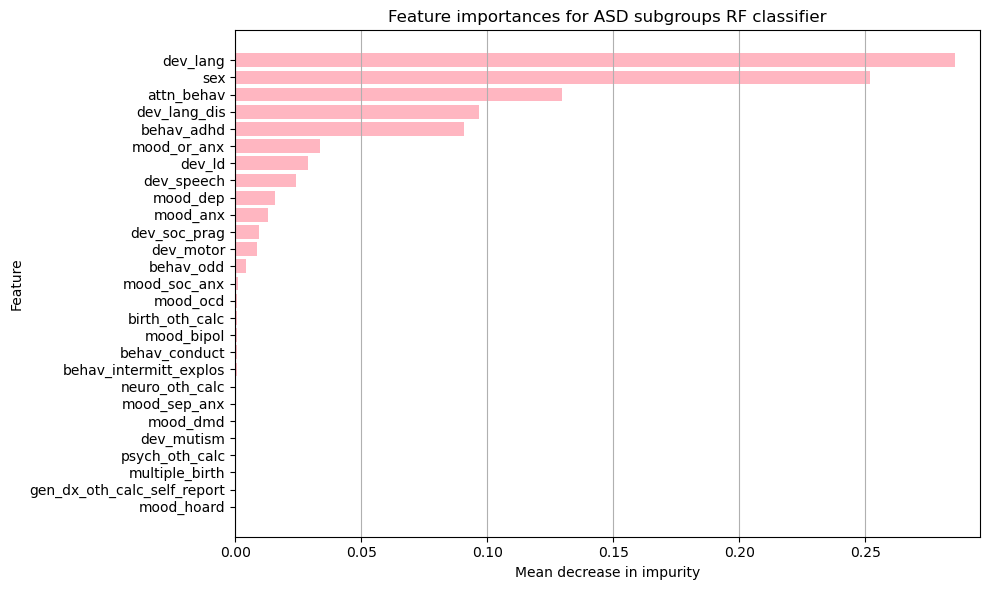

In [153]:
# variable_importance_plot(rf_importances, rf_indices, save_path='./figures/feature_importance_ASD_subgroups_all_weighted.pdf')
variable_importance_plot(rf_importances, rf_indices)

### Cross validation

In [154]:
# Perform Cross_validation to see how robust our model is 
import time

def cross_val_metrics(fit, X_train, y_train, estimator, print_results = True):
    start = time.time()
    """
    Returns Mean Accurancy with standard_dev of model over Kfolds Validation
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
                from cross validation score's standard deviation)
    """
    my_estimators = {
    'rf': 'estimators_',
    'nn': 'out_activation_',
    'knn': '_fit_method'
    }
    try:
        # Checks whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Checks whether the model has been trained
        if not vars(fit)[my_estimators[estimator]]:
            return print("Model does not appear to be trained.")

    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
              \nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    # create KFolds validation
    n = KFold(n_splits=10)

    # record score for each split
    scores = cross_val_score(fit, 
                         X_train, 
                         y_train, 
                         cv = n)
    end = time.time() 
    # print how much time the Kfolds took
    print("Time elapsed to do Cross Validation: {0:.2f} seconds.".format(end-start))
    if print_results:
        for i in range(0, len(scores)):
            # print out the scores for each validation split
            print("Cross validation run {0}: {1: 0.3f}".format(i, scores[i]))

        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})".format(scores.mean(), scores.std() / 2))     
    else:
        return scores.mean(), scores.std() / 2

In [155]:
# call cross_val_metrics to see how our model did
cross_val_metrics(rf_classifier, 
                  X_train, 
                  y_train, 
                  'rf',
                  print_results = True)

Time elapsed to do Cross Validation: 18.08 seconds.
Cross validation run 0:  0.942
Cross validation run 1:  0.943
Cross validation run 2:  0.940
Cross validation run 3:  0.940
Cross validation run 4:  0.938
Cross validation run 5:  0.941
Cross validation run 6:  0.949
Cross validation run 7:  0.943
Cross validation run 8:  0.942
Cross validation run 9:  0.941
Accuracy:  0.942 (+/-  0.001)


In [156]:
# make a prediction on test set now that the model has been tuned and validated
rf_predictions = rf_classifier.predict(X_test)

In [157]:

def create_conf_mat(y_test, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(y_test.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics; Compute a simple cross tabulation of two (or more) factors. 
        # By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.
        test_crosstb_comp = pd.crosstab(index = y_test,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

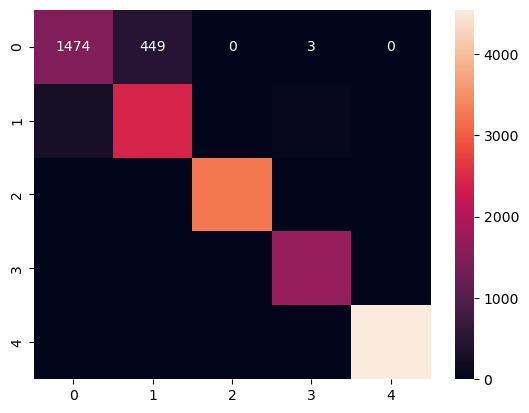

array([[1474,  449,    0,    3,    0],
       [ 282, 2428,    0,   61,    0],
       [   0,    0, 3255,    0,    0],
       [   0,    0,    0, 1713,    0],
       [   0,    0,    0,    0, 4542]])

In [158]:
conf_mat = create_conf_mat(y_test, rf_predictions)

# use seaborn heatmap
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=True)
# plt.xlabel('Predicted Values')
# plt.ylabel('Actual Values')
# plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

conf_mat


## Test set performance

In [159]:
# use built in score function to get accurancy of this model against the test set
rf_accuracy = rf_classifier.score(X_test, y_test)

print("Here is our mean accuracy on the test set:\n {0:.4f}"\
      .format(rf_accuracy))

Here is our mean accuracy on the test set:
 0.9440


In [161]:
# Here we calculate the test error rate!
rf_test_error_rate = 1 - rf_accuracy
print("The test error rate for our model is:\n {0: .4f}"\
      .format(rf_test_error_rate))

The test error rate for our model is:
  0.0560


Set up for ROC (receiver operating characteristic) curve which calculates the false positive rates and true positive rates across different thresholds.

An ideal model will have a false positive rate of 0 and true positive rate of 1. Most the curve will be in the top left corner of the graph.

On the other hand, a ROC curve that is at 45 degrees is indicative of a model that is essentially randomly guessing. Most of the curve will be in the middle of the graph.

In [160]:
# predict_proba returns two arrays that represent the predicted_prob of negative class and positive class respectively.

# I just want to take the positive classes in this instance
predictions_prob = rf_classifier.predict_proba(X_test)[:, 1]

# use roc_curve to produce 
fpr2, tpr2, _ = roc_curve(y_test,
                          predictions_prob,
                          pos_label = 1)

auc_rf = auc(fpr2, tpr2)

print(auc_rf)

0.9697872041779845


In [162]:
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

/tmp/ipykernel_1232421/2153116955.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
/tmp/ipykernel_1232421/2153116955.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')


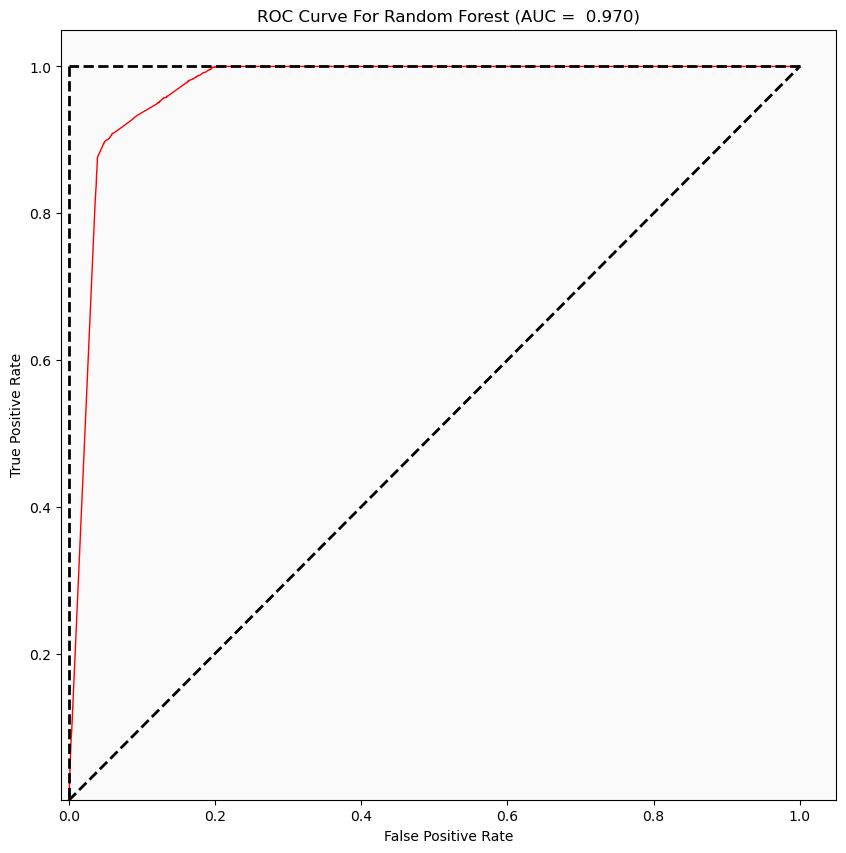

In [163]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

In [164]:
# # zoom in
# plot_roc_curve(fpr2, tpr2, auc_rf, 'rf', 
#                xlim=(-0.01, 0.2), 
#                ylim=(0.85, 1.01))

In [165]:
def print_class_report(predictions, alg_name):
    # print some title
    print('Classification Report for {0}:'.format(alg_name))
    # print class report metrics for each target 
    print(classification_report(predictions, 
            y_test, 
            target_names = [str(i) for i in np.unique(predictions)]))

In [166]:
class_report = print_class_report(rf_predictions, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1756
           1       0.88      0.84      0.86      2877
           2       1.00      1.00      1.00      3255
           3       1.00      0.96      0.98      1777
           4       1.00      1.00      1.00      4542

    accuracy                           0.94     14207
   macro avg       0.93      0.93      0.93     14207
weighted avg       0.95      0.94      0.94     14207

